# U-Net CNN Model

## Model Building

In [ ]:
import tensorflow as tf

In [ ]:
# Defining the Convolutional Block
def conv_block(inputs, num_filters):
    # Applying the sequence of Convolutional, Batch Normalization
    # and Activation Layers to the input tensor
    x = tf.keras.Sequential([
        # Convolutional Layer
        tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
        # Batch Normalization Layer
        tf.keras.layers.BatchNormalization(),
        # Activation Layer
        tf.keras.layers.Activation('relu'),
        # Convolutional Layer
        tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
        # Batch Normalization Layer
        tf.keras.layers.BatchNormalization(),
        # Activation Layer
        tf.keras.layers.Activation('relu')
    ])(inputs)

    # Returning the output of the Convolutional Block
    return x

In [ ]:
# Defining the Unet++ Model
def unet_pp(input_shape=(256, 256, 3), num_classes=1, deep_supervision=True):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoding Path
    x_00 = conv_block(inputs, 64)
    x_10 = conv_block(tf.keras.layers.MaxPooling2D()(x_00), 128)
    x_20 = conv_block(tf.keras.layers.MaxPooling2D()(x_10), 256)
    x_30 = conv_block(tf.keras.layers.MaxPooling2D()(x_20), 512)
    x_40 = conv_block(tf.keras.layers.MaxPooling2D()(x_30), 1024)

    # Nested Decoding Path
    x_01 = conv_block(tf.keras.layers.concatenate(
        [x_00, tf.keras.layers.UpSampling2D()(x_10)]), 64)
    x_11 = conv_block(tf.keras.layers.concatenate(
        [x_10, tf.keras.layers.UpSampling2D()(x_20)]), 128)
    x_21 = conv_block(tf.keras.layers.concatenate(
        [x_20, tf.keras.layers.UpSampling2D()(x_30)]), 256)
    x_31 = conv_block(tf.keras.layers.concatenate(
        [x_30, tf.keras.layers.UpSampling2D()(x_40)]), 512)

    x_02 = conv_block(tf.keras.layers.concatenate(
        [x_00, x_01, tf.keras.layers.UpSampling2D()(x_11)]), 64)
    x_12 = conv_block(tf.keras.layers.concatenate(
        [x_10, x_11, tf.keras.layers.UpSampling2D()(x_21)]), 128)
    x_22 = conv_block(tf.keras.layers.concatenate(
        [x_20, x_21, tf.keras.layers.UpSampling2D()(x_31)]), 256)

    x_03 = conv_block(tf.keras.layers.concatenate(
        [x_00, x_01, x_02, tf.keras.layers.UpSampling2D()(x_12)]), 64)
    x_13 = conv_block(tf.keras.layers.concatenate(
        [x_10, x_11, x_12, tf.keras.layers.UpSampling2D()(x_22)]), 128)

    x_04 = conv_block(tf.keras.layers.concatenate(
        [x_00, x_01, x_02, x_03, tf.keras.layers.UpSampling2D()(x_13)]), 64)

    # Deep Supervision Path
    # If deep supervision is enabled, then the model will output the segmentation maps
    # at each stage of the decoding path
    if deep_supervision:
        outputs = [
            tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(x_01),
            tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(x_02),
            tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(x_03),
            tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(x_04)
        ]
    else:
        outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(x_04)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
input_shape = (128, 128, 3)
model = unet_pp(input_shape, num_classes=1, deep_supervision=False)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_45 (Sequential)  (None, 128, 128, 64)         39232     ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 64)           0         ['sequential_45[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 sequential_46 (Sequential)  (None, 64, 64, 128)          222464    ['max_pooling2d_12[0][0]

## Getting Train-Valid-Test Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

# TRAIN
trainimageNP = np.load("/content/drive/My Drive/MANDIBLE/train_img.npy")
trainmaskNP = np.load("/content/drive/My Drive/MANDIBLE/train_mask.npy")

# VALID
validimageNP = np.load("/content/drive/My Drive/MANDIBLE/valid_img.npy")
validmaskNP = np.load("/content/drive/My Drive/MANDIBLE/valid_mask.npy")

# TEST
testimageNP = np.load("/content/drive/My Drive/MANDIBLE/test_img.npy")
testmaskNP = np.load("/content/drive/My Drive/MANDIBLE/test_mask.npy")

In [ ]:
trainmaskNP = trainmaskNP.reshape((-1, 128, 128, 1))
validmaskNP = validmaskNP.reshape((-1, 128, 128, 1))
testmaskNP = testmaskNP.reshape((-1, 128, 128, 1))

print(trainimageNP.shape)
print(trainmaskNP.shape)
print(validimageNP.shape)
print(validmaskNP.shape)
print(testimageNP.shape)
print(testmaskNP.shape)

(1626, 128, 128, 3)
(1626, 128, 128, 1)
(465, 128, 128, 3)
(465, 128, 128, 1)
(233, 128, 128, 3)
(233, 128, 128, 1)


## Epoch Training

In [ ]:
lr = 1e-4
batchSize = 32
epochs = 25

In [ ]:
drive_path = '/content/drive/My Drive/MANDIBLE/models/unetpp.keras'

In [ ]:
import time
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Compile the model
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Calculate steps per epoch and validation steps
stepsPerEpoch = len(trainimageNP) // batchSize
validationSteps = len(validimageNP) // batchSize

# Define callbacks
callbacks = [
    ModelCheckpoint(drive_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min")
]

# Record the start time
start_time = time.time()

# Train the model
history = model.fit(trainimageNP, trainmaskNP,
                    batch_size=batchSize,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(validimageNP, validmaskNP),
                    validation_steps=validationSteps,
                    steps_per_epoch=stepsPerEpoch,
                    shuffle=True,
                    callbacks=callbacks
                    )

# Record the end time
end_time = time.time()

# Calculate the training duration
training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/25
50/50 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9483
Epoch 1: val_loss improved from inf to 0.49575, saving model to /content/drive/My Drive/MANDIBLE/models/unetpp.keras
50/50 [==============================] - 84s 1s/step - loss: 0.1953 - accuracy: 0.9483 - val_loss: 0.4957 - val_accuracy: 0.8353 - lr: 1.0000e-04
Epoch 2/25
50/50 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9796
Epoch 2: val_loss improved from 0.49575 to 0.44190, saving model to /content/drive/My Drive/MANDIBLE/models/unetpp.keras
50/50 [==============================] - 68s 1s/step - loss: 0.0973 - accuracy: 0.9796 - val_loss: 0.4419 - val_accuracy: 0.8353 - lr: 1.0000e-04
Epoch 3/25
50/50 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9854
Epoch 3: val_loss improved from 0.44190 to 0.43434, saving model to /content/drive/My Drive/MANDIBLE/models/unetpp.keras
50/50 [==============================] - 67s 1s/step - loss: 0.0776

## Performance Visualization

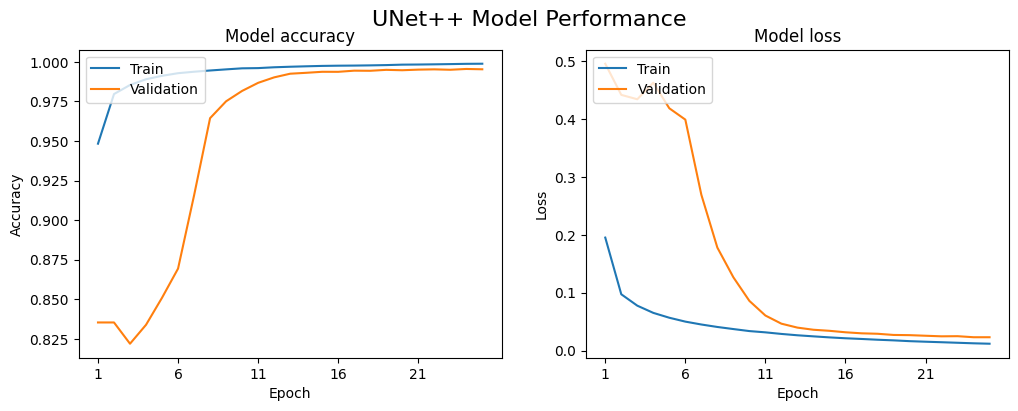

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Determine the number of epochs
epochs = len(history.history['accuracy'])
interval = 5

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'])
plt.plot(range(1, epochs + 1), history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(1, epochs + 1, interval))  # Set x-ticks with interval

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'])
plt.plot(range(1, epochs + 1), history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(1, epochs + 1, interval))  # Set x-ticks with interval

# Add an overall title
plt.suptitle('UNet++ Model Performance', fontsize=16)

plt.show()

## Evaluating on Test Set

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model(drive_path)

test_loss, test_accuracy = best_model.evaluate(testimageNP, testmaskNP, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

8/8 [==============================] - 12s 1s/step - loss: 0.0254 - accuracy: 0.9947
Test Loss: 0.0254078209400177
Test Accuracy: 0.9946561455726624
